# RL Basics for LLM Training

This notebook explains the core RL concepts we'll use in this project.
We'll build intuition with a simple example before touching LLMs.

## What is RL, really?

**Supervised Learning**: You have (input, correct_output) pairs. Train model to predict correct_output.

**Reinforcement Learning**: You have inputs, but no "correct" outputs. Instead:
1. Model produces an output
2. You score that output (reward)
3. Model learns: "do more of what got high rewards"

For LLMs:
- Input = prompt
- Output = generated text
- Reward = some score (correctness, human preference, etc.)

## The Core Idea: Policy Gradients

An LLM is a **policy**: given a prompt, it outputs a probability distribution over possible responses.

The key insight of policy gradients:

```
If an action (generated text) got high reward:
    Make that action MORE likely
If an action got low reward:
    Make that action LESS likely
```

Mathematically, the gradient update is:
```
gradient = reward * gradient_of_log_probability(action)
```

Let's see this in code with a toy example.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Simple "bandit" problem: learn which of 3 actions gives best reward
# Action 0: reward = 0
# Action 1: reward = 1  <-- this is the best
# Action 2: reward = 0.5

TRUE_REWARDS = torch.tensor([0.0, 1.0, 0.5])

# Our "policy": just 3 learnable logits (no input, simplest possible case)
# These become probabilities via softmax
policy_logits = nn.Parameter(torch.zeros(3))  # Start uniform

optimizer = torch.optim.Adam([policy_logits], lr=0.1)

print("Initial policy (should be ~33% each):")
print(F.softmax(policy_logits, dim=0))

Initial policy (should be ~33% each):
tensor([0.3333, 0.3333, 0.3333], grad_fn=<SoftmaxBackward0>)


In [ ]:
# Training loop using REINFORCE algorithm
history = []

for step in range(200):
    # 1. Sample an action from our policy
    probs = F.softmax(policy_logits, dim=0)
    action = torch.multinomial(probs, 1).item()
    
    # 2. Get reward for that action
    reward = TRUE_REWARDS[action]
    
    # 3. Compute REINFORCE gradient
    # Loss = -reward * log(probability of action taken)
    # 
    # Why this formula?
    # 1. log_prob: The gradient of log P(action) is (1/P) * grad_P, which gives us
    #    the right scaling for the policy gradient theorem
    # 2. * reward: Higher reward -> stronger push to increase P(action)
    # 3. Negative sign: Optimizers MINIMIZE loss, but we want to MAXIMIZE reward
    #    So loss = -reward * log_prob means: minimize loss = maximize reward
    #
    # IMPORTANT: With non-negative rewards (like ours: 0, 0.5, 1.0):
    # - reward=0: loss=0, NO gradient, action probability unchanged
    # - reward>0: loss<0 after backprop pushes to INCREASE P(action)
    # The "decrease" happens INDIRECTLY: softmax is zero-sum, so when P(action 1)
    # goes up, P(action 0) and P(action 2) must go down.
    # 
    # To EXPLICITLY decrease bad actions, we need NEGATIVE rewards (or a baseline).
    # That's what the next section demonstrates!
    #
    # log_softmax computes log(softmax(logits)) = log(probabilities)
    # More numerically stable than: torch.log(F.softmax(policy_logits, dim=0)[action])
    log_prob = F.log_softmax(policy_logits, dim=0)[action]
    loss = -reward * log_prob
    
    # NOTE: Loss doesn't decrease monotonically! This is NORMAL in RL.
    # Why? Because loss = -reward * log_prob(action_taken)
    # - Loss is STOCHASTIC: depends on which random action was sampled
    # - High loss can mean learning is happening (high reward action sampled)
    # - Zero loss means no learning (zero reward action sampled)
    # The REAL metric is the PROBABILITIES - watch them converge!
    
    # 4. Update policy
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    history.append({
        'step': step,
        'action': action,
        'reward': reward.item(),
        'probs': probs.detach().clone()
    })

print("Final policy (should favor action 1):")
print(F.softmax(policy_logits, dim=0))

Final policy (should favor action 1):
tensor([0.0011, 0.9940, 0.0049], grad_fn=<SoftmaxBackward0>)


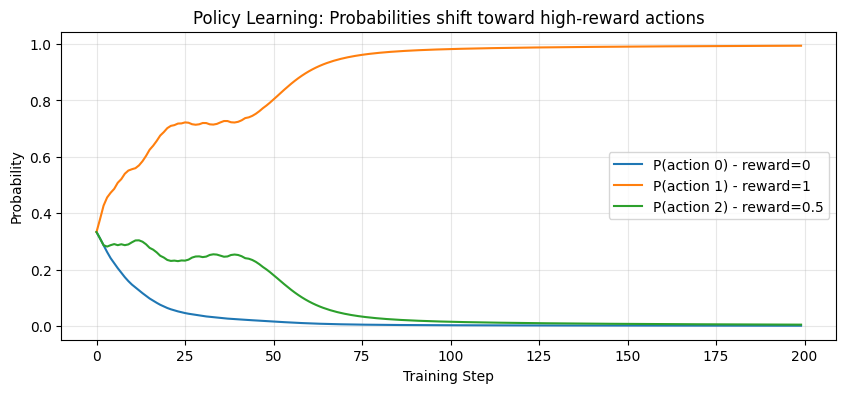

In [3]:
# Visualize learning
steps = [h['step'] for h in history]
prob_0 = [h['probs'][0].item() for h in history]
prob_1 = [h['probs'][1].item() for h in history]
prob_2 = [h['probs'][2].item() for h in history]

plt.figure(figsize=(10, 4))
plt.plot(steps, prob_0, label='P(action 0) - reward=0')
plt.plot(steps, prob_1, label='P(action 1) - reward=1')
plt.plot(steps, prob_2, label='P(action 2) - reward=0.5')
plt.xlabel('Training Step')
plt.ylabel('Probability')
plt.title('Policy Learning: Probabilities shift toward high-reward actions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Key Insight

Notice what happened:
- We never told the model "action 1 is correct"
- We just gave it rewards after each action
- It learned to prefer high-reward actions

This is the essence of RL!

## The Problem: All Positive Rewards

What if all our rewards are positive? Let's try rewards [0.8, 0.9, 1.0].

Now EVERY action gets a positive signal! The model tries to increase the probability of everything it samples. Learning becomes slow and noisy because:
1. Action 0 (reward=0.8): "increase my probability!"
2. Action 1 (reward=0.9): "increase my probability!"  
3. Action 2 (reward=1.0): "increase my probability!"

The only difference is HOW MUCH each gets pushed up. This works eventually (softmax redistribution), but it's inefficient.

In [ ]:
# Compare: No Baseline vs With Baseline
# Rewards are ALL POSITIVE: [0.8, 0.9, 1.0]
# Action 2 is best, but only slightly better than others

ALL_POSITIVE_REWARDS = torch.tensor([0.8, 0.9, 1.0])

def train_policy(rewards, use_baseline=False, steps=300, lr=0.1, seed=42):
    """Train a policy with or without baseline subtraction."""
    torch.manual_seed(seed)
    
    logits = nn.Parameter(torch.zeros(3))
    opt = torch.optim.Adam([logits], lr=lr)
    history = []
    
    # For baseline: track running average of rewards
    reward_avg = rewards.mean().item()  # Start with true mean as estimate
    
    for step in range(steps):
        probs = F.softmax(logits, dim=0)
        action = torch.multinomial(probs, 1).item()
        reward = rewards[action].item()
        
        # THE KEY DIFFERENCE: baseline subtraction
        if use_baseline:
            # Advantage = how much better than average?
            advantage = reward - reward_avg
            # Update running average (exponential moving average)
            reward_avg = 0.9 * reward_avg + 0.1 * reward
        else:
            advantage = reward  # No baseline, just raw reward
        
        log_prob = F.log_softmax(logits, dim=0)[action]
        loss = -advantage * log_prob
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        history.append({
            'step': step,
            'probs': probs.detach().clone(),
            'advantage': advantage
        })
    
    return history, F.softmax(logits, dim=0).detach()

# Train both versions
history_no_baseline, final_no_baseline = train_policy(ALL_POSITIVE_REWARDS, use_baseline=False)
history_with_baseline, final_with_baseline = train_policy(ALL_POSITIVE_REWARDS, use_baseline=True)

print("Rewards: [0.8, 0.9, 1.0] - Action 2 is best")
print(f"\nNo baseline final:   {final_no_baseline.numpy().round(3)}")
print(f"With baseline final: {final_with_baseline.numpy().round(3)}")

Rewards: [0.8, 0.9, 1.0] - Action 2 is best

No baseline final:   [0.017 0.016 0.967]
With baseline final: [0.001 0.002 0.997]


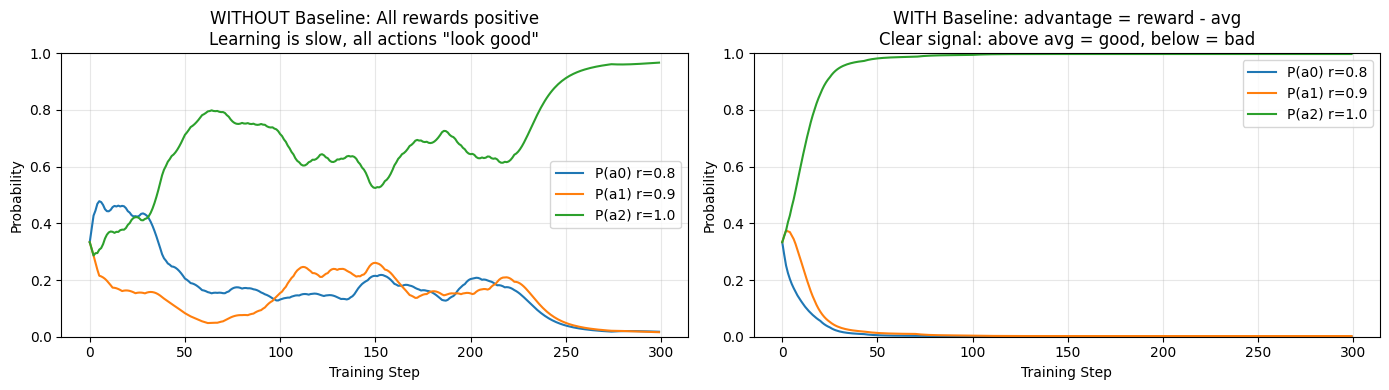

In [7]:
# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot 1: No baseline
ax1 = axes[0]
steps = [h['step'] for h in history_no_baseline]
for i, label in enumerate(['P(a0) r=0.8', 'P(a1) r=0.9', 'P(a2) r=1.0']):
    probs = [h['probs'][i].item() for h in history_no_baseline]
    ax1.plot(steps, probs, label=label)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Probability')
ax1.set_title('WITHOUT Baseline: All rewards positive\nLearning is slow, all actions "look good"')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot 2: With baseline
ax2 = axes[1]
for i, label in enumerate(['P(a0) r=0.8', 'P(a1) r=0.9', 'P(a2) r=1.0']):
    probs = [h['probs'][i].item() for h in history_with_baseline]
    ax2.plot(steps, probs, label=label)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Probability')
ax2.set_title('WITH Baseline: advantage = reward - avg\nClear signal: above avg = good, below = bad')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### What the Baseline Does

With baseline subtraction, we compute **advantage** instead of raw reward:
```
advantage = reward - baseline
```

This transforms our signals:
| Action | Reward | Advantage (reward - 0.9 avg) | Signal |
|--------|--------|------------------------------|--------|
| 0 | 0.8 | -0.1 | DECREASE probability |
| 1 | 0.9 | 0.0 | No change |
| 2 | 1.0 | +0.1 | INCREASE probability |

Now we have **explicit negative signals** for below-average actions!

**This is the core idea behind PPO and GRPO:**
- **PPO**: Learns a "value function" V(state) to predict expected reward, uses `advantage = reward - V(state)`
- **GRPO**: Samples K responses, computes `advantage = reward - mean(rewards in group)` - no learned baseline needed!

## From Bandits to LLMs

For LLMs, the same principle applies:

| Bandit | LLM |
|--------|-----|
| Action = one of 3 choices | Action = entire generated sequence |
| Policy = 3 probabilities | Policy = LLM (huge probability distribution over sequences) |
| Reward = fixed per action | Reward = f(prompt, response) e.g., "is answer correct?" |

The REINFORCE gradient is the same:
```
loss = -reward * log_probability(generated_sequence)
```

For a sequence, log_probability is the sum of log probs of each token.

## The Variance Problem and PPO

REINFORCE has a problem: **high variance**.

Imagine rewards are always positive (0.8, 0.9, 1.0). Then EVERY action gets reinforced!
The model doesn't know which actions are *relatively* better.

**Solution 1: Baselines**
Instead of `reward`, use `reward - baseline` where baseline is the average reward.
Now actions better than average get positive signal, worse get negative.

**Solution 2: PPO (Proximal Policy Optimization)**
PPO adds:
1. A learned baseline (called "value function" or "critic")
2. Clipping to prevent updates that are too large
3. Multiple gradient steps per batch of data

PPO is the industry standard for RLHF. The `trl` library implements it.

**Solution 3: GRPO (Group Relative Policy Optimization)**
Instead of learning a baseline, GRPO generates multiple responses per prompt,
then uses the average reward of the group as the baseline.
Simpler than PPO, works well for LLMs.

## What is RLVR?

RLVR = Reinforcement Learning with Verifiable Rewards

In standard RLHF, you need humans to score outputs. Expensive!

In RLVR, you use **automatic verification**:
- Math problems: parse the answer, check if it equals ground truth
- Code problems: run the code, check if tests pass

This is perfect for learning RL because:
1. No need for human labelers
2. Clear, interpretable rewards (correct = 1, wrong = 0)
3. Easy to debug

Our project uses RLVR on math problems (GSM8K).

## Next Steps

1. **02_trl_intro.ipynb**: Use the `trl` library to run actual RL on a small LLM
2. **03_gsm8k_reward.ipynb**: Build our answer verification (reward function)
3. **04_pseudo_labeling.ipynb**: Implement consensus-based pseudo-labeling

Then we'll be ready to run the full noisy student loop!